In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np

In [2]:
dialogue_dir = "dialogue_data"
train_data_path = os.path.join(dialogue_dir, "train_data.json")
train_csv_path = os.path.join(dialogue_dir, "train_data.csv")

# Loading Data

In [3]:
# Creating a single json file for all the training dialogues

train_data = []
train_dir = os.path.join(dialogue_dir, "train")
for dialogue in os.listdir(train_dir):
    dialogue_path = os.path.join(train_dir, dialogue)
    with open(dialogue_path, "r") as train_json:
        dialogues = json.load(train_json)
        train_data.extend(dialogues)
    train_json.close()

with open(train_data_path, "w") as train_json:
    json.dump(train_data, train_json, indent=2)
train_json.close()

In [5]:
# Creating a csv file for the dialogues train dataset

with open(train_data_path, "r") as train_json:
    train_data = json.load(train_json)
train_json.close()

train_csv = []

for dialogue in train_data:
    for turn in dialogue["turns"]:
        row = {}
        row["Speaker"] = turn["speaker"]
        row["Turn ID"] = turn["turn_id"]
        row["Utterence"] = turn["utterance"]
        row["Dialogue ID"] = dialogue["dialogue_id"]
        row["Intent"] = ""
        train_csv.append(row)
train_csv = pd.DataFrame(train_csv, columns=["Dialogue ID", "Speaker", "Turn ID", "Utterence", "Intent"])
train_csv.to_csv(train_csv_path, index=False)

# Bulk Labelling

In [3]:
import pathlib 
import numpy as np
import pandas as pd
import ipywidgets as widgets

from whatlies import EmbeddingSet 
from whatlies.transformers import Pca, Umap
from hulearn.preprocessing import InteractivePreprocessor
from hulearn.experimental.interactive import InteractiveCharts
from whatlies.language import UniversalSentenceLanguage, LaBSELanguage, DIETLanguage, FloretLanguage

In [5]:
no_samples = 1000

train_csv = pd.read_csv(train_csv_path)

user_dialogue = train_csv[train_csv["Speaker"]=="USER"]
user_dialogue = user_dialogue.drop_duplicates("Utterence", keep="first", inplace=False, ignore_index=True)
user_dialogue = user_dialogue.sample(no_samples, ignore_index=True)

In [6]:
user_dialogue

,Dialogue ID,Speaker,Turn ID,Utterence,Intent
0,PMUL4781.json,USER,8,Yes. I want a reservation for 4 nights startin...,NaN
1,SNG0352.json,USER,2,Sorry. I want to leave on Saturday after 20:30.,NaN
2,SNG01830.json,USER,0,I would like to find a hospital with a diabete...,NaN
3,MUL1098.json,USER,2,Yes. I would like it to be a guesthouse with a...,NaN
4,SNG0657.json,USER,0,I want to eat fine british food.,NaN
...,...,...,...,...,...
995,PMUL4948.json,USER,20,rad that's all i need now,NaN
996,MUL0715.json,USER,4,"Yes, I'd like a booking for 2 people, please.",NaN
997,MUL1825.json,USER,10,"That would be great, could you book it for 7 p...",NaN
998,PMUL2444.json,USER,16,Thanks! Looking forward to it!,NaN


In [7]:
texts = user_dialogue["Utterence"].to_list()
print(len(texts))

1000


In [8]:
# The language agnostic bert model works is a good starting option, 
# especially for Non-English use-cases but it is a fair bit slower.
# You can swap this out with another embedding source if you feel like though. 
# lang = LaBSELanguage()
lang = UniversalSentenceLanguage(variant="large")
# lang = DIETLanguage()
# lang = FloretLanguage()

In [9]:
# This is where we prepare all of the state
embset = lang[texts]
df = embset.transform(Umap(2)).to_dataframe().reset_index()
df.columns = ['text', 'd1', 'd2']
df['label'] = ''

In [10]:
df

,text,d1,d2,label
0,Yes. I want a reservation for 4 nights startin...,8.348385,5.471253,
1,Sorry. I want to leave on Saturday after 20:30.,10.936522,6.791087,
2,I would like to find a hospital with a diabete...,12.453556,4.494893,
3,Yes. I would like it to be a guesthouse with a...,9.587939,-1.165027,
4,I want to eat fine british food.,13.498782,-1.474881,
...,...,...,...,...
995,rad that's all i need now,3.596505,3.885370,
996,"Yes, I'd like a booking for 2 people, please.",8.172438,4.960354,
997,"That would be great, could you book it for 7 p...",8.833070,4.553936,
998,Thanks! Looking forward to it!,3.201789,4.260702,


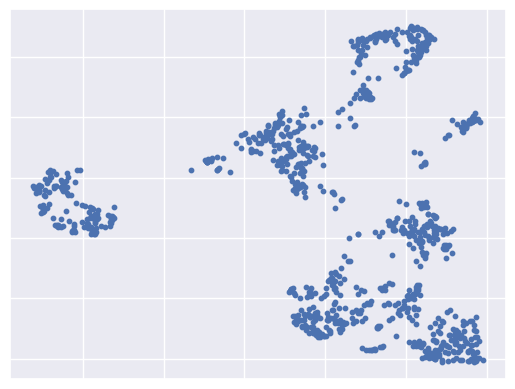

In [11]:
data = df[["d1", "d2"]].to_numpy()
plt.scatter(data[:, 0], data[:, 1], s=10)
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

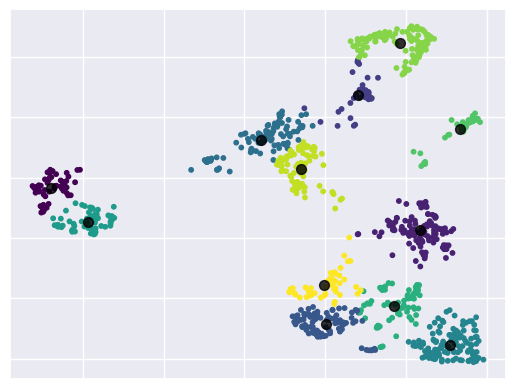

In [16]:
from sklearn.cluster import KMeans, SpectralClustering
model = KMeans(n_clusters=12)
# model = SpectralClustering(n_clusters=12, affinity='nearest_neighbors', assign_labels='kmeans')
y_kmeans = model.fit_predict(data)

plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=10, cmap='viridis')
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.8)

In [17]:
user_dialogue["Intent"] = y_kmeans
user_dialogue.to_csv("./dialogue_data/user_dialogue_raw.csv", index=False)

In [29]:
# Here's the global state object
state = {}
state['df'] = df.copy()
state['chart'] = InteractiveCharts(df.loc[lambda d: d['label'] == ''], labels=['group'])

Loading BokehJS ...

In [53]:
pd.set_option('display.max_colwidth', -1)

def show_draw_chart(b=None):
    with out_table:
        out_table.clear_output()
    with out_chart:
        out_chart.clear_output()
        state['chart'].dataf = state['df'].loc[lambda d: d['label'] == '']
        state['chart'].charts = []
        state['chart'].add_chart(x='d1', y='d2', legend=False)

def show_examples(b=None):
    with out_table:
        out_table.clear_output()
        tfm = InteractivePreprocessor(json_desc=state['chart'].data())
        subset = state['df'].pipe(tfm.pandas_pipe).loc[lambda d: d['group'] != 0]
        display(subset.sample(min(15, subset.shape[0]))[['text']])

def assign_label(b=None):
    tfm = InteractivePreprocessor(json_desc=state['chart'].data())
    idx = state['df'].pipe(tfm.pandas_pipe).loc[lambda d: d['group'] != 0].index
    state['df'].iloc[idx, 3] = label_name.value
    with out_counter:
        out_counter.clear_output()
        n_lab = state['df'].loc[lambda d: d['label'] != ''].shape[0]
        print(f"{n_lab}/{state['df'].shape[0]} labelled")

def retrain_state(b=None):
    keep = list(state['df'].loc[lambda d: d['label'] == '']['text'])
    umap = Umap(2)
    new_df = EmbeddingSet(*[e for e in embset if e.name in keep]).transform(umap).to_dataframe().reset_index()
    new_df.columns = ['text', 'd1', 'd2']
    new_df['label'] = ''
    state['df'] = pd.concat([new_df, state['df'].loc[lambda d: d['label'] != '']])
    show_draw_chart(b)

out_table = widgets.Output()
out_chart = widgets.Output()
out_counter = widgets.Output()

label_name = widgets.Text("label name")

btn_examples = widgets.Button(
    description='Show Examples',
    icon='eye'
)

btn_label = widgets.Button(
    description='Add label',
    icon='check'
)

btn_retrain = widgets.Button(
    description='Retrain',
    icon='coffee'
)

btn_redraw = widgets.Button(
    description='Redraw',
    icon='check'
)

btn_examples.on_click(show_examples)
btn_label.on_click(assign_label)
btn_redraw.on_click(show_draw_chart)
btn_retrain.on_click(retrain_state)

show_draw_chart()
display(widgets.VBox([widgets.HBox([btn_retrain, btn_examples, btn_redraw]), 
                      widgets.HBox([out_chart, out_table])]), 
        label_name, 
        widgets.HBox([btn_label, out_counter]))

Text(value='label name')

In [20]:
# This is the dataframe with the labels attached
# you can inspect it here or save it to disk.
state['df']

,text,d1,d2,label
0,Are there any restaurants in the centre that serves North American type of food?,12.759892,-1.162512,
1,"Oh wait, you know what? I forgot to ask about star ratings. What's the star rating on the A and B Guest House, please?",7.568747,-1.182581,
2,I am leaving cambridge on Tuesday and going to Birmingham new street.,13.244747,4.254968,
3,"That's okay, could you provide me with the postcode and address, please? Also, I am looking for a train leaving after 16:00 this Monday.",10.788860,6.066881,
4,"I'm awful with math, what is the travel time on that train?",10.355771,5.620865,
...,...,...,...,...
983,"Looking for something in the North, cheap price range please. Don't care much about internet.",9.402921,-1.351047,
984,What is the travel time for the one arriving at 1:44.,10.176835,5.471220,
985,I'm looking for a train from Cambridge to Leicester on Monday.,12.928972,5.968725,
986,Would 1 night work instead? If it does could I get the reference number please?,7.994438,5.547698,


In [ ]:
for i in range(len(user_dialogue)):
    user_dialogue.iloc[i]["Intent"] = state['df'].iloc[i]["label"]

In [ ]:
user_dialogue.to_csv("./dialogue_data/user_dialogue.csv", index=False)